# Effective TensorFlow

Table of Contents
=================
1.  [TensorFlow Basics](#basics)
2.  [Understanding static and dynamic shapes](#shapes)
3.  [Scopes and when to use them](#scopes)
4.  [Broadcasting the good and the ugly](#broadcast)
5.  [Feeding data to TensorFlow](#data)
6.  [Take advantage of the overloaded operators](#overloaded_ops)
7.  [Understanding order of execution and control dependencies](#control_deps)
8.  [Control flow operations: conditionals and loops](#control_flow)
9.  [Prototyping kernels and advanced visualization with Python ops](#python_ops)
10. [Multi-GPU processing with data parallelism](#multi_gpu)
11. [Debugging TensorFlow models](#debug)
12. [Numerical stability in TensorFlow](#stable)
13. [Building a neural network training framework with learn API](#tf_learn)
14. [TensorFlow Cookbook](#cookbook)
    - [Get shape](#get_shape)
    - [Batch gather](#batch_gather)
    - [Beam search](#beam_search)
    - [Merge](#merge)
    - [Entropy](#entropy)
    - [KL-Divergence](#kld)
    - [Make parallel](#make_parallel)
    - [Leaky Relu](#leaky_relu)
    - [Batch normalization](#batch_norm)
    - [Squeeze and excitation](#squeeze_excite)
---

_We aim to gradually expand this series by adding new articles and keep the content up to date with the latest releases of TensorFlow API. If you have suggestions on how to improve this series or find the explanations ambiguous, feel free to create an issue, send patches, or reach out by email._

You can instantiate a notebook with the following examples in your browser using Binder (click the badge):
[![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/MTDzi/EffectiveTensorflow/master?filepath=interactive_README.ipynb)
or create an environment:
```
conda env create -f environment.yml
```
and run the `"interactive_README.ipynb"` notebook on your local machine.

 _We encourage you to also check out the accompanied neural network training framework built on top of tf.contrib.learn API. The [framework](https://github.com/vahidk/TensorflowFramework) can be downloaded separately:_
```
git clone https://github.com/vahidk/TensorflowFramework.git
```

## TensorFlow Basics
<a name="basics"></a>

----

The most striking difference between TensorFlow and other numerical computation libraries such as NumPy is that operations in TensorFlow are symbolic. This is a powerful concept that allows TensorFlow to do all sort of things (e.g. automatic differentiation) that are not possible with imperative libraries such as NumPy. But it also comes at the cost of making it harder to grasp. Our attempt here is to demystify TensorFlow and provide some guidelines and best practices for more effective use of TensorFlow.

Let's start with a simple example, we want to multiply two random matrices. First we look at an implementation done in NumPy:

In [1]:
import numpy as np

x = np.random.normal(size=[10, 10])
y = np.random.normal(size=[10, 10])
z = np.dot(x, y)

print(z)

[[ 0.33506556 -1.92051947  1.24966103 -1.441302   -2.33778091 -0.92004128
   0.3528933  -1.35291822 -5.74160725  4.13097862]
 [ 5.16051298 -1.74648305  0.63312533  0.6345477  -5.14912498 -3.14657604
   4.67122929 -1.96464437 -3.67286487  8.07623614]
 [-9.54564418  0.01978381 -0.78708805 -1.94097347 -2.46701981 -2.61148512
   2.79005648 -2.4820765  -4.11839773  3.3102521 ]
 [-1.91475766  2.33804904  3.08252975  0.55329343  0.79815378 -0.9520832
  -2.19402428 -5.31708456  2.21496819 -2.9704033 ]
 [ 5.78112082  0.55552211 -1.75945165  3.73823514  0.95317343 -4.41783183
   0.46856631 -3.27263025 11.95820552 -4.78841132]
 [-0.01722493  3.17097782  2.11062793  2.60194065 -1.06477111 -0.33434253
   3.94145134 -6.67459619  2.66564045 -1.15411406]
 [-5.1843071  -0.37290951  2.37552427 -4.02839167 -0.79393593 -3.06887879
  -2.87036291 -2.3097315  -2.91406877  1.6983707 ]
 [ 0.9860788   1.04696697  1.83856081  0.66378277 -0.72823486 -2.014445
   0.52305257 -3.85150924  5.86387712 -1.23919099]
 [1

Now we perform the exact same computation this time in TensorFlow:

In [2]:
import tensorflow as tf

x = tf.random_normal([10, 10])
y = tf.random_normal([10, 10])
z = tf.matmul(x, y)

sess = tf.Session()
z_val = sess.run(z)

print(z_val)

[[ -2.4345832    3.8221192    2.1889088    3.204807     1.0029178
   -0.4557373   -4.542382    -2.6108572    2.6987057    3.5270607 ]
 [  2.0852349    0.05060711  -0.31593266  -3.2071402   -3.5876083
    1.0430559    0.31015456   3.7093697    2.7167494   -3.3673105 ]
 [ -3.3902383    3.5423172   -2.4867976   -0.03914188   1.9021473
    1.0211391    4.571634    -2.1809785    0.33308855   1.7985543 ]
 [  8.224139    -4.625705     3.9353917   -7.667169   -12.632673
   -0.189795    -5.5649686    7.531027     1.9325986   -5.36115   ]
 [  7.5594034    1.1332451   -0.1916025   -2.4874988    0.643606
   -7.369633    -3.936945     4.361122     1.853346    -1.2904589 ]
 [ -1.5619348    2.0944054   -0.7255132    0.6776398    0.7410711
   -3.041604    -1.3553785    2.5189588    0.6356331   -1.3279319 ]
 [ -8.58872      3.2367764   -3.3985682    5.6320643    2.753151
    2.761128     4.133904    -8.0938      -1.6886839   -0.31788078]
 [  5.832029    -2.93794     -0.48153558  -2.5728471    0.9030847

Unlike NumPy that immediately performs the computation and produces the result, tensorflow only gives us a handle (of type Tensor) to a node in the graph that represents the result. If we try printing the value of z directly, we get something like this:

In [3]:
z

<tf.Tensor 'MatMul:0' shape=(10, 10) dtype=float32>

Since both the inputs have a fully defined shape, tensorflow is able to infer the shape of the tensor as well as its type. In order to compute the value of the tensor we need to create a session and evaluate it using Session.run() method.


***
__Tip__: When using Jupyter notebook make sure to call tf.reset_default_graph() at the beginning to clear the symbolic graph before defining new nodes.
***

To understand how powerful symbolic computation can be let's have a look at another example. Assume that we have samples from a curve (say f(x) = 5x^2 + 3) and we want to estimate f(x) based on these samples. We define a parametric function g(x, w) = w0 x^2 + w1 x + w2, which is a function of the input x and latent parameters w, our goal is then to find the latent parameters such that g(x, w) ≈ f(x). This can be done by minimizing the following loss function: L(w) = &sum; (f(x) - g(x, w))^2. Although there's a closed form solution for this simple problem, we opt to use a more general approach that can be applied to any arbitrary differentiable function, and that is using stochastic gradient descent. We simply compute the average gradient of L(w) with respect to w over a set of sample points and move in the opposite direction.


Here's how it can be done in TensorFlow:

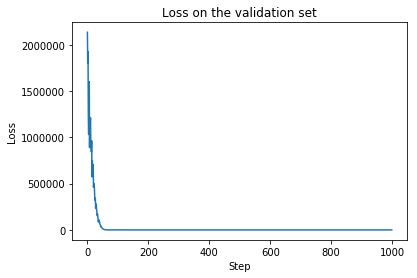

[array([[4.9994798e+00],
       [5.8107158e-05],
       [3.0306935e+00]], dtype=float32)]


In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline


# Placeholders are used to feed values from python to TensorFlow ops. We define
# two placeholders, one for input feature x, and one for output y.
x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)

# Assuming we know that the desired function is a polynomial of 2nd degree, we
# allocate a vector of size 3 to hold the coefficients. The variable will be
# automatically initialized with random noise.
w = tf.get_variable("w", shape=[3, 1])

# We define yhat to be our estimate of y.
f = tf.stack([tf.square(x), x, tf.ones_like(x)], 1)
yhat = tf.squeeze(tf.matmul(f, w), 1)

# The loss is defined to be the l2 distance between our estimate of y and its
# true value. We also added a shrinkage term, to ensure the resulting weights
# would be small.
loss = tf.nn.l2_loss(yhat - y) + 0.1 * tf.nn.l2_loss(w)

# We use the Adam optimizer with learning rate set to 0.1 to minimize the loss.
train_op = tf.train.AdamOptimizer(0.1).minimize(loss)

def generate_data():
    x_val = np.random.uniform(-10.0, 10.0, size=100)
    y_val = 5 * np.square(x_val) + 3
    return x_val, y_val

sess = tf.Session()

losses_val = []
# Since we are using variables we first need to initialize them.
sess.run(tf.global_variables_initializer())
for _ in range(1000):
    x_val, y_val = generate_data()
    _, loss_val = sess.run([train_op, loss], {x: x_val, y: y_val})
    losses_val.append(loss_val)
    
plt.plot(losses_val)
plt.title('Loss on the validation set')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

print(sess.run([w]))

By running this piece of code you should see a result close to this:
```
[4.9924135, 0.00040895029, 3.4504161]
```
Which is a relatively close approximation to our parameters.

This is just tip of the iceberg for what TensorFlow can do. Many problems such as optimizing large neural networks with millions of parameters can be implemented efficiently in TensorFlow in just a few lines of code. TensorFlow takes care of scaling across multiple devices, and threads, and supports a variety of platforms.

## Understanding static and dynamic shapes
<a name="shapes"></a>
Tensors in TensorFlow have a static shape attribute which is determined during graph construction. The static shape may be underspecified. For example we might define a tensor of shape [None, 128]:

In [5]:
import tensorflow as tf


a = tf.placeholder(tf.float32, [None, 128])

This means that the first dimension can be of any size and will be determined dynamically during Session.run(). You can query the static shape of a Tensor as follows:

In [6]:
a.shape.as_list()

[None, 128]

To get the dynamic shape of the tensor you can call tf.shape op, which returns a tensor representing the shape of the given tensor:

In [7]:
tf.shape(a)

<tf.Tensor 'Shape:0' shape=(2,) dtype=int32>

The static shape of a tensor can be set with Tensor.set_shape() method:

In [8]:
a.set_shape([32, 128])  # static shape of a is [32, 128]
a.set_shape([None, 128])  # first dimension of a is determined dynamically

You can reshape a given tensor dynamically using tf.reshape function:

In [9]:
a =  tf.reshape(a, [32, 128])
a

<tf.Tensor 'Reshape:0' shape=(32, 128) dtype=float32>

It can be convenient to have a function that returns the static shape when available and dynamic shape when it's not. The following utility function does just that:

In [10]:
def get_shape(tensor):
    static_shape = tensor.shape.as_list()
    dynamic_shape = tf.unstack(tf.shape(tensor))
    dims = [s[1] if s[0] is None else s[0]
            for s in zip(static_shape, dynamic_shape)]
    return dims

Now imagine we want to convert a Tensor of rank 3 to a tensor of rank 2 by collapsing the second and third dimensions into one. We can use our get_shape() function to do that:

In [11]:
b = tf.placeholder(tf.float32, [None, 10, 32])
shape = get_shape(b)
b = tf.reshape(b, [shape[0], shape[1] * shape[2]])
b

<tf.Tensor 'Reshape_1:0' shape=(?, 320) dtype=float32>

Note that this works whether the shapes are statically specified or not.

In fact we can write a general purpose reshape function to collapse any list of dimensions:

In [12]:
import tensorflow as tf
import numpy as np


def reshape(tensor, dims_list):
    shape = get_shape(tensor)
    dims_prod = []
    for dims in dims_list:
        if isinstance(dims, int):
            dims_prod.append(shape[dims])
        elif all([isinstance(shape[d], int) for d in dims]):
            dims_prod.append(np.prod([shape[d] for d in dims]))
        else:
            dims_prod.append(tf.prod([shape[d] for d in dims]))
    tensor = tf.reshape(tensor, dims_prod)
    return tensor

Then collapsing the second dimension becomes very easy:

In [13]:
b = tf.placeholder(tf.float32, [None, 10, 32])
b = reshape(b, [0, [1, 2]])
b

<tf.Tensor 'Reshape_2:0' shape=(?, 320) dtype=float32>

## Scopes and when to use them
<a name="scopes"></a>

Variables and tensors in TensorFlow have a name attribute that is used to identify them in the symbolic graph. If you don't specify a name when creating a variable or a tensor, TensorFlow automatically assigns a name for you:

In [14]:
a = tf.constant(1)
print(a.name)

b = tf.Variable(1)
print(b.name)

Const:0
Variable:0


You can overwrite the default name by explicitly specifying it:

In [15]:
a = tf.constant(1, name="a")
print(a.name)

b = tf.Variable(1, name="b")
print(b.name)

a:0
b:0


TensorFlow introduces two different context managers to alter the name of tensors and variables. The first is tf.name_scope:

In [16]:
with tf.name_scope("scope"):
    a = tf.constant(1, name="a")
    print(a.name)

    b = tf.Variable(1, name="b")
    print(b.name)

    c = tf.get_variable(name="c", shape=[])
    print(c.name)

scope/a:0
scope/b:0
c:0


Note that there are two ways to define new variables in TensorFlow, by creating a tf.Variable object or by calling tf.get_variable. Calling tf.get_variable with a new name results in creating a new variable, but if a variable with the same name exists it will raise a ValueError exception, telling us that re-declaring a variable is not allowed.

tf.name_scope affects the name of tensors and variables created with tf.Variable, but doesn't impact the variables created with tf.get_variable.

Unlike tf.name_scope, tf.variable_scope modifies the name of variables created with tf.get_variable as well:

In [17]:
with tf.variable_scope("scope"):
    a = tf.constant(1, name="a")
    print(a.name)

    b = tf.Variable(1, name="b")
    print(b.name)

    c = tf.get_variable(name="c", shape=[])
    print(c.name)

scope_1/a:0
scope_1/b:0
scope/c:0


In [18]:
with tf.variable_scope("scope"):
    a1 = tf.get_variable(name="a", shape=[])
    # Disallowed
    # a2 = tf.get_variable(name="a", shape=[])

But what if we actually want to reuse a previously declared variable? Variable scopes also provide the functionality to do that:

In [19]:
# We've defined a1 above, so in order to create it again, we need to reset
# the default graph
tf.reset_default_graph()

with tf.variable_scope("scope"):
    a1 = tf.get_variable(name="a", shape=[])
    
with tf.variable_scope("scope", reuse=True):
    a2 = tf.get_variable(name="a", shape=[])  # OK

This becomes handy for example when using built-in neural network layers:

In [20]:
image1 = tf.placeholder(tf.float32, shape=[None, 100, 100, 3])
image2 = tf.placeholder(tf.float32, shape=[None, 100, 100, 3])

conv1_weights = tf.get_variable('conv1_w', [3, 3, 3, 64])
features1 = tf.nn.conv2d(image1, conv1_weights, strides=[1, 1, 1, 1], padding='SAME')

# Use the same convolution weights to process the second image
with tf.variable_scope(tf.get_variable_scope(), reuse=True):
    conv1_weights = tf.get_variable('conv1_w')
    features2 = tf.nn.conv2d(image2, conv1_weights, strides=[1, 1, 1, 1], padding='SAME')

This syntax may not look very clean to some. Especially if you want to do lots of variable sharing keeping track of when to define new variables and when to reuse them can be cumbersome and error prone. TensorFlow templates are designed to handle this automatically:

In [21]:
conv3x32 = tf.make_template("conv3x32", lambda x: tf.layers.conv2d(x, 32, 3))
features1 = conv3x32(image1)
features2 = conv3x32(image2)  # Will reuse the convolution weights.

You can turn any function to a TensorFlow template. Upon the first call to a template, the variables defined inside the function would be declared and in the consecutive invocations they would automatically get reused.

## Broadcasting the good and the ugly
<a name="broadcast"></a>
TensorFlow supports broadcasting elementwise operations. Normally when you want to perform operations like addition and multiplication, you need to make sure that shapes of the operands match, e.g. you can’t add a tensor of shape [3, 2] to a tensor of shape [3, 4]. But there’s a special case and that’s when you have a singular dimension. TensorFlow implicitly tiles the tensor across its singular dimensions to match the shape of the other operand. So it’s valid to add a tensor of shape [3, 2] to a tensor of shape [3, 1]

In [22]:
a = tf.constant([[1., 2.], [3., 4.]])
b = tf.constant([[1.], [2.]])
# c = a + tf.tile(b, [1, 2])
c = a + b

Broadcasting allows us to perform implicit tiling which makes the code shorter, and more memory efficient, since we don’t need to store the result of the tiling operation. One neat place that this can be used is when combining features of varying length. In order to concatenate features of varying length we commonly tile the input tensors, concatenate the result and apply some nonlinearity. This is a common pattern across a variety of neural network architectures:

In [23]:
a = tf.random_uniform([5, 3, 5])
b = tf.random_uniform([5, 1, 6])

# concat a and b and apply nonlinearity
tiled_b = tf.tile(b, [1, 3, 1])
c = tf.concat([a, tiled_b], 2)
d = tf.layers.dense(c, 10, activation=tf.nn.relu)

But this can be done more efficiently with broadcasting. We use the fact that f(m(x + y)) is equal to f(mx + my). So we can do the linear operations separately and use broadcasting to do implicit concatenation:

In [24]:
pa = tf.layers.dense(a, 10, activation=None)
pb = tf.layers.dense(b, 10, activation=None)
d = tf.nn.relu(pa + pb)

In fact this piece of code is pretty general and can be applied to tensors of arbitrary shape as long as broadcasting between tensors is possible:

In [25]:
def merge(a, b, units, activation=tf.nn.relu):
    pa = tf.layers.dense(a, units, activation=None)
    pb = tf.layers.dense(b, units, activation=None)
    c = pa + pb
    if activation is not None:
        c = activation(c)
    return c

A slightly more general form of this function is [included](#merge) in the cookbook.

So far we discussed the good part of broadcasting. But what’s the ugly part you may ask? Implicit assumptions almost always make debugging harder to do. Consider the following example:

In [26]:
a = tf.constant([[1.], [2.]])
b = tf.constant([1., 2.])
c = tf.reduce_sum(a + b)

What do you think the value of c would be after evaluation? If you guessed 6, that’s wrong. It’s going to be 12. This is because when rank of two tensors don’t match, TensorFlow automatically expands the first dimension of the tensor with lower rank before the elementwise operation, so the result of addition would be [[2, 3], [3, 4]], and the reducing over all parameters would give us 12.

In [27]:
sess = tf.Session()
sess.run(c)

12.0

The way to avoid this problem is to be as explicit as possible. Had we specified which dimension we would want to reduce across, catching this bug would have been much easier:

In [28]:
a = tf.constant([[1.], [2.]])
b = tf.constant([1., 2.])
c = tf.reduce_sum(a + b, 0)
sess.run(c)

array([5., 7.], dtype=float32)

Here the value of c is [5, 7], and we immediately would guess based on the shape of the result that there’s something wrong. A general rule of thumb is to always specify the dimensions in reduction operations and when using tf.squeeze.

## Feeding data to TensorFlow
<a name="data"></a>

TensorFlow is designed to work efficiently with large amount of data. So it's important not to starve your TensorFlow model in order to maximize its performance. There are various ways that you can feed your data to TensorFlow.

### Constants
The simplest approach is to embed the data in your graph as a constant:

In [29]:
actual_data = np.random.normal(size=[100])

data = tf.constant(actual_data)

This approach can be very efficient, but it's not very flexible. One problem with this approach is that, in order to use your model with another dataset you have to rewrite the graph. Also, you have to load all of your data at once and keep it in memory which would only work with small datasets.

### Placeholders
Using placeholders solves both of these problems:

In [30]:
data = tf.placeholder(tf.float32)

prediction = tf.square(data) + 1

actual_data = np.random.normal(size=[100])

tf.Session().run(prediction, feed_dict={data: actual_data})

array([3.2893856, 1.3812246, 1.0105637, 2.8357956, 1.7246213, 1.0263269,
       1.0352184, 5.0141535, 1.0276434, 1.0721049, 1.8218842, 1.8604174,
       1.2118263, 4.107312 , 1.2012012, 1.0280517, 1.145581 , 2.3486667,
       3.3652995, 2.5457802, 2.4618096, 5.824673 , 1.921036 , 1.5295633,
       1.0822468, 3.7660904, 1.1037974, 2.3502538, 1.3710458, 1.0126232,
       1.6218619, 1.0129203, 1.2460276, 1.081219 , 2.0438168, 1.107834 ,
       2.631594 , 1.3232273, 1.3067122, 1.3220989, 2.641674 , 1.3825661,
       1.2325377, 1.1238017, 1.2339326, 1.4505538, 2.2763596, 2.3518248,
       5.656122 , 1.3685396, 1.7468526, 1.0377201, 2.8086982, 1.2096725,
       1.0034273, 3.0375617, 2.1057918, 2.9201016, 3.3050432, 1.8073102,
       5.6860623, 1.4754865, 3.664821 , 1.2741984, 2.8509731, 1.0103812,
       6.014603 , 1.280214 , 6.06176  , 1.0279971, 5.805291 , 1.02622  ,
       4.607512 , 1.328998 , 1.681742 , 1.445168 , 3.1434953, 1.0145942,
       1.1283582, 2.461885 , 1.004383 , 2.2205186, 

Placeholder operator returns a tensor whose value is fetched through the feed_dict argument in Session.run function. Note that running Session.run without feeding the value of data in this case will result in an error.

### Python ops
Another approach to feed the data to TensorFlow is by using Python ops:

In [31]:
def py_input_fn():
    actual_data = np.random.normal(size=[100])
    return actual_data

data = tf.py_func(py_input_fn, [], (tf.float32))

Python ops allow you to convert a regular Python function to a TensorFlow operation.

### Dataset API
The recommended way of reading the data in TensorFlow however is through the dataset API:

In [32]:
actual_data = np.random.normal(size=[100])
dataset = tf.data.Dataset.from_tensor_slices(actual_data)
data = dataset.make_one_shot_iterator().get_next()

If you need to read your data from file, it may be more efficient to write it in TFrecord format and use TFRecordDataset to read it:

```python
dataset = tf.contrib.data.TFRecordDataset(path_to_data)
```

See the [official docs](https://www.tensorflow.org/api_guides/python/reading_data#Reading_from_files) for an example of how to write your dataset in TFrecord format.

Dataset API allows you to make efficient data processing pipelines easily. For example this is how we process our data in the accompanied framework (See
[trainer.py](https://github.com/vahidk/TensorflowFramework/blob/master/trainer.py)):

```python
dataset = ...
dataset = dataset.cache()
if mode == tf.estimator.ModeKeys.TRAIN:
    dataset = dataset.repeat()
    dataset = dataset.shuffle(batch_size * 5)
dataset = dataset.map(parse, num_threads=8)
dataset = dataset.batch(batch_size)
```

After reading the data, we use Dataset.cache method to cache it into memory for improved efficiency. During the training mode, we repeat the dataset indefinitely. This allows us to process the whole dataset many times. We also shuffle the dataset to get batches with different sample distributions. Next, we use the Dataset.map function to perform preprocessing on raw records and convert the data to a usable format for the model. We then create batches of samples by calling Dataset.batch.

## Take advantage of the overloaded operators
<a name="overloaded_ops"></a>
Just like NumPy, TensorFlow overloads a number of python operators to make building graphs easier and the code more readable.

The slicing op is one of the overloaded operators that can make indexing tensors very easy:
```python
z = x[begin:end]  # z = tf.slice(x, [begin], [end-begin])
```

Be very careful when using this op though. The slicing op is very inefficient and often better avoided, especially when the number of slices is high. To understand how inefficient this op can be let's look at an example. We want to manually perform reduction across the rows of a matrix:

In [33]:
import time


x = tf.random_uniform([500, 10])

z = tf.zeros([10])
for i in range(500):
    z += x[i]

sess = tf.Session()

%time sess.run(z);

CPU times: user 1.41 s, sys: 5.85 ms, total: 1.41 s
Wall time: 1.41 s


array([252.36804, 244.6605 , 254.10976, 245.649  , 255.49844, 251.41347,
       250.5014 , 253.3366 , 236.23166, 248.47911], dtype=float32)

On my MacBook Pro, this took 976 ms to run! The reason is that we are calling the slice op 500 times, which is going to be very slow to run. A better choice would have been to use tf.unstack op to slice the matrix into a list of vectors all at once:

In [34]:
%%time
z = tf.zeros([10])
for x_i in tf.unstack(x):
    z += x_i

CPU times: user 258 ms, sys: 3.82 ms, total: 262 ms
Wall time: 262 ms


This took 277 ms. Of course, the right way to do this simple reduction is to use tf.reduce_sum op:

In [35]:
%time z = tf.reduce_sum(x, axis=0)

CPU times: user 2.99 ms, sys: 0 ns, total: 2.99 ms
Wall time: 2.95 ms


This took 3.36 ms, which is ~300x faster than the original implementation.

TensorFlow also overloads a range of arithmetic and logical operators:

In [36]:
x = tf.random_uniform([500, 10])
y = tf.random_uniform([500, 10])

z = -x  # z = tf.negative(x)
z = x + y  # z = tf.add(x, y)
z = x - y  # z = tf.subtract(x, y)
z = x * y  # z = tf.mul(x, y)
z = x / y  # z = tf.div(x, y)
z = x // y  # z = tf.floordiv(x, y)
z = x % y  # z = tf.mod(x, y)
z = x ** y  # z = tf.pow(x, y)
z = x @ tf.transpose(y)  # z = tf.matmul(x, y)
z = x > y  # z = tf.greater(x, y)
z = x >= y  # z = tf.greater_equal(x, y)
z = x < y  # z = tf.less(x, y)
z = x <= y  # z = tf.less_equal(x, y)
z = abs(x)  # z = tf.abs(x)


# Now, for logical operations
x = tf.constant([True, False])
y = tf.constant([True, True])

z = x & y  # z = tf.logical_and(x, y)
z = x | y  # z = tf.logical_or(x, y)
z = x ^ y  # z = tf.logical_xor(x, y)
z = ~x  # z = tf.logical_not(x)

You can also use the augmented version of these ops. For example `x += y` and `x **= 2` are also valid.

Note that Python doesn't allow overloading "`and`", "`or`", and "`not`" keywords.

TensorFlow also doesn't allow using tensors as booleans, as it may be error prone:

In [37]:
x = tf.constant(1.)
# This would raise a TypeError error
# if x: 
#    ...

You can either use tf.cond(x, ...) if you want to check the value of the tensor, or use "if x is None" to check the value of the variable.

Other operators that aren't supported are equal (`==`) and not equal (`!=`) operators which are overloaded in NumPy but not in TensorFlow. Use the function versions instead which are `tf.equal` and `tf.not_equal`.


## Understanding order of execution and control dependencies
<a name="control_deps"></a>
As we discussed in the first item, TensorFlow doesn't immediately run the operations that are defined but rather creates corresponding nodes in a graph that can be evaluated with Session.run() method. This also enables TensorFlow to do optimizations at run time to determine the optimal order of execution and possible trimming of unused nodes. If you only have tf.Tensors in your graph you don't need to worry about dependencies but you most probably have tf.Variables too, and tf.Variables make things much more difficult. My advice to is to only use Variables if Tensors don't do the job. This might not make a lot of sense to you now, so let's start with an example.

In [38]:
a = tf.constant(1)
b = tf.constant(2)
a = a + b

sess.run(a)

3

Evaluating "a" will return the value 3 as expected.  Note that here we are creating 3 tensors, two constant tensors and another tensor that stores the result of the addition. Note that you can't overwrite the value of a tensor. If you want to modify it you have to create a new tensor. As we did here.

***
__TIP__: If you don't define a new graph, TensorFlow automatically creates a graph for you by default. You can use tf.get_default_graph() to get a handle to the graph. You can then inspect the graph, for example by printing all its tensors:

In [39]:
# The list of tensors defined so far is quite long, so I'm showing only
# the last 10 elements
tf.contrib.graph_editor.get_tensors(tf.get_default_graph())[-10:]

[<tf.Tensor 'or:0' shape=(2,) dtype=bool>,
 <tf.Tensor 'xor/LogicalOr:0' shape=(2,) dtype=bool>,
 <tf.Tensor 'xor/LogicalAnd:0' shape=(2,) dtype=bool>,
 <tf.Tensor 'xor/LogicalNot:0' shape=(2,) dtype=bool>,
 <tf.Tensor 'xor:0' shape=(2,) dtype=bool>,
 <tf.Tensor 'LogicalNot:0' shape=(2,) dtype=bool>,
 <tf.Tensor 'Const_10:0' shape=() dtype=float32>,
 <tf.Tensor 'Const_11:0' shape=() dtype=int32>,
 <tf.Tensor 'Const_12:0' shape=() dtype=int32>,
 <tf.Tensor 'add_1006:0' shape=() dtype=int32>]

Unlike tensors, variables can be updated. So let's see how we may use variables to do the same thing:

In [40]:
a = tf.Variable(1)
b = tf.constant(2)
assign = tf.assign(a, a + b)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
print(sess.run(assign))

3


Again, we get 3 as expected. Note that tf.assign returns a tensor representing the value of the assignment.
So far everything seemed to be fine, but let's look at a slightly more complicated example:

In [41]:
a = tf.Variable(1)
b = tf.constant(2)
c = a + b

assign = tf.assign(a, 5)

sess = tf.Session()
for i in range(10):
    sess.run(tf.global_variables_initializer())
    print(sess.run([assign, c]))

[5, 3]
[5, 3]
[5, 7]
[5, 7]
[5, 7]
[5, 7]
[5, 7]
[5, 7]
[5, 7]
[5, 7]


Note that the tensor c here won't have a deterministic value. This value might be 3 or 7 depending on whether addition or assignment gets executed first.

**You should note that the order that you define ops in your code doesn't matter to TensorFlow runtime.** The only thing that matters is the control dependencies. Control dependencies for tensors are straightforward. Every time you use a tensor in an operation that op will define an implicit dependency to that tensor. But things get complicated with variables because they can take many values.

When dealing with variables, you may need to explicitly define dependencies using tf.control_dependencies() as follows:

In [42]:
a = tf.Variable(1)
b = tf.constant(2)
c = a + b

with tf.control_dependencies([c]):
    assign = tf.assign(a, 5)

sess = tf.Session()
for i in range(10):
    sess.run(tf.global_variables_initializer())
    print(sess.run([assign, c]))

[5, 3]
[5, 3]
[5, 3]
[5, 3]
[5, 3]
[5, 3]
[5, 3]
[5, 3]
[5, 3]
[5, 3]


This will make sure that the assign op will be called after the addition.

## Control flow operations: conditionals and loops
<a name="control_flow"></a>
When building complex models such as recurrent neural networks you may need to control the flow of operations through conditionals and loops. In this section we introduce a number of commonly used control flow ops.

Let's assume you want to decide whether to multiply to or add two given tensors based on a predicate. This can be simply implemented with tf.cond which acts as a python "if" function:

In [43]:
a = tf.constant(1)
b = tf.constant(2)

p = tf.constant(True)

x = tf.cond(p, lambda: a + b, lambda: a * b)

print(tf.Session().run(x))

3


Since the predicate is True in this case, the output would be the result of the addition, which is 3.

Most of the times when using TensorFlow you are using large tensors and want to perform operations in batch. A related conditional operation is tf.where, which like tf.cond takes a predicate, but selects the output based on the condition in batch.

In [44]:
a = tf.constant([1, 1])
b = tf.constant([2, 2])

p = tf.constant([True, False])

x = tf.where(p, a + b, a * b)  # Similar to np.where

print(tf.Session().run(x))

[3 2]


Another widely used control flow operation is tf.while_loop. It allows building dynamic loops in TensorFlow that operate on sequences of variable length. Let's see how we can generate Fibonacci sequence with tf.while_loops:

In [45]:
n = tf.constant(5)


def cond(i, a, b):
    return i < n


def body(i, a, b):
    return i + 1, b, a + b


i, a, b = tf.while_loop(cond, body, (2, 1, 1))

print(tf.Session().run(b))

5


This will print 5. tf.while_loops takes a condition function, and a loop body function, in addition to initial values for loop variables. These loop variables are then updated by multiple calls to the body function until the condition returns false.

Now imagine we want to keep the whole series of Fibonacci sequence. We may update our body to keep a record of the history of current values:

In [46]:
n = tf.constant(5)

def cond(i, a, b, c):
    return i < n

def body(i, a, b, c):
    return i + 1, b, a + b, tf.concat([c, [a + b]], 0)

Now if you try running this:
```python
i, a, b, c = tf.while_loop(cond, body, (2, 1, 1, tf.constant([1, 1])))
print(tf.Session().run(c))
```
TensorFlow will complain that the shape of the the fourth loop variable is changing. So you must make that explicit that it's intentional:

In [47]:
i, a, b, c = tf.while_loop(
    cond, body, (2, 1, 1, tf.constant([1, 1])),
    shape_invariants=(
        tf.TensorShape([]),
        tf.TensorShape([]),
        tf.TensorShape([]),
        tf.TensorShape([None])
    )
)

This is not only getting ugly, but is also somewhat inefficient. Note that we are building a lot of intermediary tensors that we don't use. TensorFlow has a better solution for this kind of growing arrays. Meet tf.TensorArray. Let's do the same thing this time with tensor arrays:

In [48]:
n = tf.constant(5)

c = tf.TensorArray(tf.int32, n)
c = c.write(0, 1)
c = c.write(1, 1)

def cond(i, a, b, c):
    return i < n

def body(i, a, b, c):
    c = c.write(i, a + b)
    return i + 1, b, a + b, c


i, a, b, c = tf.while_loop(cond, body, (2, 1, 1, c))

c = c.stack()

print(tf.Session().run(c))

[1 1 2 3 5]


TensorFlow while loops and tensor arrays are essential tools for building complex recurrent neural networks. As an exercise try implementing [beam search](https://en.wikipedia.org/wiki/Beam_search) using tf.while_loops. Can you make it more efficient with tensor arrays?

## Prototyping kernels and advanced visualization with Python ops
<a name="python_ops"></a>
Operation kernels in TensorFlow are entirely written in C++ for efficiency. But writing a TensorFlow kernel in C++ can be quite a pain. So, before spending hours implementing your kernel you may want to prototype something quickly, however inefficient. With tf.py_func() you can turn any piece of python code to a TensorFlow operation.

For example this is how you can implement a simple ReLU nonlinearity kernel in TensorFlow as a python op:

In [49]:
import uuid


def relu(inputs):
    # Define the op in python
    def _relu(x):
        return np.maximum(x, 0.)

    # Define the op's gradient in python
    def _relu_grad(x):
        return np.float32(x > 0)

    # An adapter that defines a gradient op compatible with TensorFlow
    def _relu_grad_op(op, grad):
        x = op.inputs[0]
        x_grad = grad * tf.py_func(_relu_grad, [x], tf.float32)
        return x_grad

    # Register the gradient with a unique id
    grad_name = "MyReluGrad_" + str(uuid.uuid4())
    tf.RegisterGradient(grad_name)(_relu_grad_op)

    # Override the gradient of the custom op
    g = tf.get_default_graph()
    with g.gradient_override_map({"PyFunc": grad_name}):
        output = tf.py_func(_relu, [inputs], tf.float32)
        
    return output

To verify that the gradients are correct you can use TensorFlow's gradient checker:

In [50]:
x = tf.random_normal([10])
y = relu(x * x)

with tf.Session():
    diff = tf.test.compute_gradient_error(x, [10], y, [10])
    print(diff)

3.62396240234375e-05


compute_gradient_error() computes the gradient numerically and returns the difference with the provided gradient. What we want is a very low difference.

Note that this implementation is pretty inefficient, and is only useful for prototyping, since the python code is not parallelizable and won't run on GPU. Once you verified your idea, you definitely would want to write it as a C++ kernel.

In practice we commonly use python ops to do visualization on Tensorboard. Consider the case that you are building an image classification model and want to visualize your model predictions during training. TensorFlow allows visualizing images with tf.summary.image() function:

In [51]:
image = tf.placeholder(tf.float32)
tf.summary.image("image", image)

<tf.Tensor 'image:0' shape=() dtype=string>

But this only visualizes the input image. In order to visualize the predictions you have to find a way to add annotations to the image which may be almost impossible with existing ops. An easier way to do this is to do the drawing in python, and wrap it in a python op:
```python
import io
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf


def visualize_labeled_images(images, labels, max_outputs=3, name="image"):
    def _visualize_image(image, label):
        # Do the actual drawing in python
        fig = plt.figure(figsize=(3, 3), dpi=80)
        ax = fig.add_subplot(111)
        ax.imshow(image[::-1,...])
        ax.text(0, 0, str(label),
          horizontalalignment="left",
          verticalalignment="top")
        fig.canvas.draw()

        # Write the plot as a memory file.
        buf = io.BytesIO()
        data = fig.savefig(buf, format="png")
        buf.seek(0)

        # Read the image and convert to numpy array
        img = PIL.Image.open(buf)
        return np.array(img.getdata()).reshape(img.size[0], img.size[1], -1)

    def _visualize_images(images, labels):
        # Only display the given number of examples in the batch
        outputs = []
        for i in range(max_outputs):
            output = _visualize_image(images[i], labels[i])
            outputs.append(output)
        return np.array(outputs, dtype=np.uint8)

    # Run the python op.
    figs = tf.py_func(_visualize_images, [images, labels], tf.uint8)
    return tf.summary.image(name, figs)
```

Note that since summaries are usually only evaluated once in a while (not per step), this implementation may be used in practice without worrying about efficiency.

## Multi-GPU processing with data parallelism
<a name="multi_gpu"></a>
 If you write your software in a language like C++ for a single cpu core, making it run on multiple GPUs in parallel would require rewriting the software from scratch. But this is not the case with TensorFlow. Because of its symbolic nature, tensorflow can hide all that complexity, making it effortless to scale your program across many CPUs and GPUs.

 Let's start with the simple example of adding two vectors on CPU:

In [52]:
with tf.device(tf.DeviceSpec(device_type="CPU", device_index=0)):
    a = tf.random_uniform([1000, 100])
    b = tf.random_uniform([1000, 100])
    c = a + b

tf.Session().run(c)

array([[1.0841011 , 1.2724384 , 0.6829829 , ..., 0.16336954, 1.0882428 ,
        1.0827421 ],
       [1.0634626 , 1.1214933 , 1.1169556 , ..., 1.2954746 , 0.79139364,
        1.6446935 ],
       [0.25241303, 1.09001   , 0.42797387, ..., 0.6408082 , 0.8262476 ,
        0.6956694 ],
       ...,
       [0.88596857, 0.41711438, 1.1332605 , ..., 0.63284254, 1.6265924 ,
        1.2412205 ],
       [0.671371  , 1.0752897 , 0.56412494, ..., 0.5936053 , 1.2320076 ,
        0.35591674],
       [1.6703444 , 1.8307495 , 0.8562156 , ..., 1.2920911 , 0.5523274 ,
        1.3104864 ]], dtype=float32)

The same thing can as simply be done on GPU:

In [53]:
with tf.device(tf.DeviceSpec(device_type="GPU", device_index=0)):
    a = tf.random_uniform([1000, 100])
    b = tf.random_uniform([1000, 100])
    c = a + b

But what if we have two GPUs and want to utilize both? To do that, we can split the data and use a separate GPU for processing each half:

In [54]:
split_a = tf.split(a, 2)
split_b = tf.split(b, 2)

split_c = []
for i in range(2):
    with tf.device(tf.DeviceSpec(device_type="GPU", device_index=i)):
        split_c.append(split_a[i] + split_b[i])

c = tf.concat(split_c, axis=0)

Let's rewrite this in a more general form so that we can replace addition with any other set of operations:

In [55]:
def make_parallel(fn, num_gpus, **kwargs):
    in_splits = {}
    for k, v in kwargs.items():
        in_splits[k] = tf.split(v, num_gpus)

    out_split = []
    for i in range(num_gpus):
        with tf.device(tf.DeviceSpec(device_type="GPU", device_index=i)):
            with tf.variable_scope(tf.get_variable_scope(), reuse=i > 0):
                out_split.append(fn(**{k : v[i] for k, v in in_splits.items()}))

    return tf.concat(out_split, axis=0)


def model(a, b):
    return a + b

c = make_parallel(model, 2, a=a, b=b)

You can replace the `model` with any function that takes a set of tensors as input and returns a tensor as result with the condition that both the input and output are in batch. Note that we also added a variable scope and set the reuse to true. This makes sure that we use the same variables for processing both splits. This is something that will become handy in our next example.

Let's look at a slightly more practical example. We want to train a neural network on multiple GPUs. During training we not only need to compute the forward pass but also need to compute the backward pass (the gradients). But how can we parallelize the gradient computation? This turns out to be pretty easy.

Recall from the first item that we wanted to fit a second degree polynomial to a set of samples. We reorganized the code a bit to have the bulk of the operations in the model function:

In [56]:
tf.reset_default_graph()


def model(x, y):
    w = tf.get_variable("w", shape=[3, 1])

    f = tf.stack([tf.square(x), x, tf.ones_like(x)], 1)
    yhat = tf.squeeze(tf.matmul(f, w), 1)

    loss = tf.square(yhat - y)
    return loss


x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)

loss = model(x, y)

train_op = tf.train.AdamOptimizer(0.1).minimize(
    tf.reduce_mean(loss))


def generate_data():
    x_val = np.random.uniform(-10.0, 10.0, size=100)
    y_val = 5 * np.square(x_val) + 3
    return x_val, y_val


sess = tf.Session()
sess.run(tf.global_variables_initializer())
for _ in range(1000):
    x_val, y_val = generate_data()
    _, loss_val = sess.run([train_op, loss], {x: x_val, y: y_val})

_, loss_val = sess.run([train_op, loss], {x: x_val, y: y_val})
print(sess.run(tf.contrib.framework.get_variables_by_name("w")))

[array([[ 4.9952149e+00],
       [-7.9514677e-05],
       [ 3.2797904e+00]], dtype=float32)]


Now let's use make_parallel that we just wrote to parallelize this. We only need to change two lines of code from the above code:
```python
loss = make_parallel(model, 2, x=x, y=y)

train_op = tf.train.AdamOptimizer(0.1).minimize(
    tf.reduce_mean(loss),
    colocate_gradients_with_ops=True)
```

The only thing that we need to change to parallelize backpropagation of gradients is to set the colocate_gradients_with_ops flag to true. This ensures that gradient ops run on the same device as the original op.

## Debugging TensorFlow models
<a name="debug"></a>
Symbolic nature of TensorFlow makes it relatively more difficult to debug TensorFlow code compared to regular python code. Here we introduce a number of tools included with TensorFlow that make debugging much easier.

Probably the most common error one can make when using TensorFlow is passing Tensors of wrong shape to ops. Many TensorFlow ops can operate on tensors of different ranks and shapes. This can be convenient when using the API, but may lead to extra headache when things go wrong.

For example, consider the tf.matmul op, it can multiply two matrices:

In [57]:
a = tf.random_uniform([2, 3])
b = tf.random_uniform([3, 4])
c = tf.matmul(a, b)  # c is a tensor of shape [2, 4]

But the same function also does batch matrix multiplication:

In [58]:
a = tf.random_uniform([10, 2, 3])
b = tf.random_uniform([10, 3, 4])
tf.matmul(a, b)  # c is a tensor of shape [10, 2, 4]

<tf.Tensor 'MatMul_2:0' shape=(10, 2, 4) dtype=float32>

Another example that we talked about before in the [broadcasting](#broadcast) section is add operation which supports broadcasting:

In [59]:
a = tf.constant([[1.], [2.]])
b = tf.constant([1., 2.])
c = a + b  # c is a tensor of shape [2, 2]

### Validating your tensors with tf.assert* ops

One way to reduce the chance of unwanted behavior is to explicitly verify the rank or shape of intermediate tensors with `tf.assert_*()` ops.

In [60]:
try:
    a = tf.constant([[1.], [2.]])
    b = tf.constant([1., 2.])
    check_a = tf.assert_rank(a, 1)  # This will raise ValueError
    check_b = tf.assert_rank(b, 1)
    with tf.control_dependencies([check_a, check_b]):
        c = a + b  # c is a tensor of shape [2, 2]
except ValueError as e:
    print('ValueError: {}'.format(e))

ValueError: .  Tensor Const_2:0 must have rank 1.  Received rank 2, shape (2, 1)


Remember that assertion nodes like other operations are part of the graph and if not evaluated would get pruned during Session.run(). So make sure to create explicit dependencies to assertion ops, to force TensorFlow to execute them.

You can also use assertions to validate the value of tensors at runtime:

In [61]:
check_pos = tf.assert_positive(a)

See the official docs for a [full list of assertion ops](https://www.tensorflow.org/api_guides/python/check_ops).

### Logging tensor values with tf.Print

Another useful built-in function for debugging is tf.Print which logs the given tensors to the standard error:
```python
input_copy = tf.Print(input, tensors_to_print_list)
```

Note that tf.Print returns a copy of its first argument as output. One way to force tf.Print to run is to pass its output to another op that gets executed. For example if we want to print the value of tensors a and b before adding them we could do something like this:

In [62]:
a = tf.constant(2)
b = tf.constant(5)

a = tf.Print(a, [a, b])
c = a + b

sess.run(c)

7

Alternatively we could manually define a control dependency.

### Check your gradients with tf.compute_gradient_error

__Not__ all the operations in TensorFlow come with gradients, and it's easy to unintentionally build graphs for which TensorFlow can not compute the gradients.

Let's look at an example:

In [63]:
import tensorflow as tf


def non_differentiable_softmax_entropy(logits):
    probs = tf.nn.softmax(logits)
    return tf.nn.softmax_cross_entropy_with_logits(labels=probs, logits=logits)


tf.reset_default_graph()

w = tf.get_variable("w", shape=[5])
y = -non_differentiable_softmax_entropy(w)

opt = tf.train.AdamOptimizer()
train_op = opt.minimize(y)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
for i in range(10000):
    sess.run(train_op)

print(sess.run(tf.nn.softmax(w)))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

[0.10460826 0.25193235 0.2302133  0.29654464 0.11670139]


We are using tf.nn.softmax_cross_entropy_with_logits to define entropy over a categorical distribution. We then use Adam optimizer to find the weights with maximum entropy. If you have passed a course on information theory, you would know that uniform distribution contains maximum entropy. So you would expect for the result to be [0.2, 0.2, 0.2, 0.2, 0.2]. But if you run this you may get unexpected results like this:
```
[ 0.34081486  0.24287023  0.23465775  0.08935683  0.09230034]
```
It turns out tf.nn.softmax_cross_entropy_with_logits has undefined gradients with respect to labels! But how may we spot this if we didn't know?

Fortunately for us TensorFlow comes with a numerical differentiator that can be used to find symbolic gradient errors. Let's see how we can use it:

In [64]:
with tf.Session():
    diff = tf.test.compute_gradient_error(w, [5], y, [])
    print(diff)

0.06818771362304688


If you run this, you would see that the difference between the numerical and symbolic gradients are pretty high (0.06 - 0.1 in my tries).

Now let's fix our function with a differentiable version of the entropy and check again:

In [65]:
import tensorflow as tf
import numpy as np


def softmax_entropy(logits, dim=-1):
    plogp = tf.nn.softmax(logits, dim) * tf.nn.log_softmax(logits, dim)
    return -tf.reduce_sum(plogp, dim)


tf.reset_default_graph()

w = tf.get_variable("w", shape=[5])
y = -softmax_entropy(w)

print(w.get_shape())
print(y.get_shape())

with tf.Session() as sess:
    diff = tf.test.compute_gradient_error(w, [5], y, [])
    print(diff)

(5,)
()
Instructions for updating:
keep_dims is deprecated, use keepdims instead
8.175522089004517e-05


The difference should be ~0.0001 which looks much better.

Now if you run the optimizer again with the correct version you can see the final weights would be:
```
[ 0.2  0.2  0.2  0.2  0.2]
```
which are exactly what we wanted.

[TensorFlow summaries](https://www.tensorflow.org/api_guides/python/summary), and [tfdbg (TensorFlow Debugger)](https://www.tensorflow.org/api_guides/python/tfdbg) are other tools that can be used for debugging. Please refer to the official docs to learn more.

## Numerical stability in TensorFlow
<a name="stable"></a>
When using any numerical computation library such as NumPy or TensorFlow, it's important to note that writing mathematically correct code doesn't necessarily lead to correct results. You also need to make sure that the computations are stable.

Let's start with a simple example. From primary school we know that x * y / y is equal to x for any non zero value of x. But let's see if that's always true in practice:

In [66]:
x = np.float32(1)

y = np.float32(1e-50)  # y would be stored as zero
z = x * y / y

print(z)

nan


/home/md/anaconda3/envs/EffectiveTensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in float_scalars
  after removing the cwd from sys.path.


The reason for the incorrect result is that y is simply too small for float32 type. A similar problem occurs when y is too large:

In [67]:
y = np.float32(1e39)  # y would be stored as inf
z = x * y / y

print(z)

nan


/home/md/anaconda3/envs/EffectiveTensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in float_scalars
  


The smallest positive value that float32 type can represent is 1.4013e-45 and anything below that would be stored as zero. Also, any number beyond 3.40282e+38, would be stored as inf:

In [68]:
print(np.nextafter(np.float32(0), np.float32(1)))
print(np.finfo(np.float32).max)

1e-45
3.4028235e+38


To make sure that your computations are stable, you want to avoid values with small or very large absolute value. This may sound very obvious, but these kind of problems can become extremely hard to debug especially when doing gradient descent in TensorFlow. This is because you not only need to make sure that all the values in the forward pass are within the valid range of your data types, but also you need to make sure of the same for the backward pass (during gradient computation).

Let's look at a real example. We want to compute the softmax over a vector of logits. A naive implementation would look something like this:

In [69]:
def unstable_softmax(logits):
    exp = tf.exp(logits)
    return exp / tf.reduce_sum(exp)


tf.Session().run(unstable_softmax([1000., 0.]))

array([nan,  0.], dtype=float32)

Note that computing the exponential of logits for relatively small numbers results to gigantic results that are out of float32 range. The largest valid logit for our naive softmax implementation is ln(3.40282e+38) = 88.7, anything beyond that leads to a `nan` outcome.

But how can we make this more stable? The solution is rather simple. It's easy to see that
$$\exp(x_j - c) \big/ \sum_i \exp(x_i - c) = \exp(x_j) \big/ \sum_i \exp(x_i).$$
Therefore we can subtract any constant from the logits and the result would remain the same. We choose this constant to be the maximum of logits. This way the domain of the exponential function would be limited to `[-inf, 0]`, and consequently its range would be `[0, 1]` which is desirable:

In [70]:
def softmax(logits):
    exp = tf.exp(logits - tf.reduce_max(logits))
    return exp / tf.reduce_sum(exp)


tf.Session().run(softmax([1000., 0.]))

array([1., 0.], dtype=float32)

Let's look at a more complicated case. Consider we have a classification problem. We use the softmax function to produce probabilities from our logits. We then define our loss function to be the cross entropy between our predictions and the labels. Recall that cross entropy for a categorical distribution can be simply defined as
$$\text{xe}(p, q) = -\sum_i p_i \log q_i.$$
So a naive implementation of the cross entropy would look like this:

In [71]:
def unstable_softmax_cross_entropy(labels, logits):
    logits = tf.log(softmax(logits))
    return -tf.reduce_sum(labels * logits)


labels = tf.constant([0.5, 0.5])
logits = tf.constant([1000., 0.])

xe = unstable_softmax_cross_entropy(labels, logits)

print(tf.Session().run(xe))

inf


Note that in this implementation as the softmax output approaches zero, the log's output approaches infinity which causes instability in our computation. We can rewrite this by expanding the softmax and doing some simplifications:

In [72]:
def softmax_cross_entropy(labels, logits):
    scaled_logits = logits - tf.reduce_max(logits)
    normalized_logits = scaled_logits - tf.reduce_logsumexp(scaled_logits)
    return -tf.reduce_sum(labels * normalized_logits)


labels = tf.constant([0.5, 0.5])
logits = tf.constant([1000., 0.])

xe = softmax_cross_entropy(labels, logits)

print(tf.Session().run(xe))

500.0


We can also verify that the gradients are also computed correctly:

In [73]:
g = tf.gradients(xe, logits)
print(tf.Session().run(g))

[array([ 0.5, -0.5], dtype=float32)]


which is correct.

Let me remind again that extra care must be taken when doing gradient descent to make sure that the range of your functions as well as the gradients for each layer are within a valid range. Exponential and logarithmic functions when used naively are especially problematic because they can map small numbers to enormous ones and the other way around.

## Building a neural network training framework with learn API
<a name="tf_learn"></a>
For simplicity, in most of the examples here we manually create sessions and we don't care about saving and loading checkpoints but this is not how we usually do things in practice. You most probably want to use the learn API to take care of session management and logging. We provide a simple but practical [framework](https://github.com/vahidk/TensorflowFramework/tree/master) for training neural networks using TensorFlow. In this item we explain how this framework works.

When experimenting with neural network models you usually have a training/test split. You want to train your model on the training set, and once in a while evaluate it on test set and compute some metrics. You also need to store the model parameters as a checkpoint, and ideally you want to be able to stop and resume training. TensorFlow's learn API is designed to make this job easier, letting us focus on developing the actual model.

The most basic way of using tf.learn API is to use tf.Estimator object directly. You need to define a model function that defines a loss function, a train op, one or a set of predictions, and optionally a set of metric ops for evaluation:
```python
def model_fn(features, labels, mode, params):
    predictions = ...
    loss = ...
    train_op = ...
    metric_ops = ...
    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=predictions,
        loss=loss,
        train_op=train_op,
        eval_metric_ops=metric_ops)


params = ...
run_config = tf.contrib.learn.RunConfig(model_dir=FLAGS.output_dir)
estimator = tf.estimator.Estimator(
    model_fn=model_fn, config=run_config, params=params)
```


To train the model you would then simply call Estimator.train() function while providing an input function to read the data:
```python
def input_fn():
    features = ...
    labels = ...
    return features, labels

estimator.train(input_fn=input_fn, max_steps=...)
```

and to evaluate the model, simply call Estimator.evaluate():
```
estimator.evaluate(input_fn=input_fn)
```

Estimator object might be good enough for simple cases, but TensorFlow provides a higher level object called Experiment which provides some additional useful functionality. Creating an experiment object is very easy:

```python
experiment = tf.contrib.learn.Experiment(
    estimator=estimator,
    train_input_fn=train_input_fn,
    eval_input_fn=eval_input_fn)
```

Now we can call train_and_evaluate function to compute the metrics while training:
```
experiment.train_and_evaluate()
```

---
An even higher level way of running experiments is by using learn_runner.run() function. Here's how our main function looks like in the provided framework:
```python
import tensorflow as tf


tf.flags.DEFINE_string("output_dir", "", "Optional output dir.")
tf.flags.DEFINE_string("schedule", "train_and_evaluate", "Schedule.")
tf.flags.DEFINE_string("hparams", "", "Hyper parameters.")

FLAGS = tf.flags.FLAGS


def experiment_fn(run_config, hparams):
  estimator = tf.estimator.Estimator(
    model_fn=make_model_fn(),
    config=run_config,
    params=hparams)
  return tf.contrib.learn.Experiment(
    estimator=estimator,
    train_input_fn=make_input_fn(tf.estimator.ModeKeys.TRAIN, hparams),
    eval_input_fn=make_input_fn(tf.estimator.ModeKeys.EVAL, hparams))


def main(unused_argv):
  run_config = tf.contrib.learn.RunConfig(model_dir=FLAGS.output_dir)
  hparams = tf.contrib.training.HParams()
  hparams.parse(FLAGS.hparams)

  estimator = tf.contrib.learn.learn_runner.run(
    experiment_fn=experiment_fn,
    run_config=run_config,
    schedule=FLAGS.schedule,
    hparams=hparams)


if __name__ == "__main__":
  tf.app.run()
```

The `"schedule"` flag decides which member function of the Experiment object gets called. So, if you for example set schedule to "train_and_evaluate", `experiment.train_and_evaluate()` would be called.

The input function returns two tensors (or dictionaries of tensors) providing the features and labels to be passed to the model:
```python
def input_fn():
    features = ...
    labels = ...
    return features, labels
```
See [mnist.py](https://github.com/vahidk/TensorflowFramework/blob/master/dataset/mnist.py) for an example of how to read your data with the dataset API. To learn about various ways of reading your data in TensorFlow refer to [this item](#data).

The framework also comes with a simple convolutional network classifier in [alexnet.py](https://github.com/vahidk/TensorflowFramework/blob/master/model/alexnet.py) that includes an example model.

And that's it! This is all you need to get started with TensorFlow learn API. I recommend to have a look at the framework [source code](https://github.com/vahidk/TensorFlowFramework) and see the official python API to learn more about the learn API.


## TensorFlow Cookbook
<a name="cookbook"></a>
This section includes implementation of a set of common operations in TensorFlow.

### Get shape <a name="get_shape"></a>

In [74]:
def get_shape(tensor):
    """Returns static shape if available and dynamic shape otherwise."""
    static_shape = tensor.shape.as_list()
    dynamic_shape = tf.unstack(tf.shape(tensor))
    dims = [s[1] if s[0] is None else s[0]
            for s in zip(static_shape, dynamic_shape)]
    return dims

### Batch Gather <a name="batch_gather"></a>

In [75]:
def batch_gather(tensor, indices):
    """Gather in batch from a tensor of arbitrary size.

    In pseudocode this module will produce the following:
    output[i] = tf.gather(tensor[i], indices[i])

    Args:
        tensor: Tensor of arbitrary size.
        indices: Vector of indices.
    Returns:
        output: A tensor of gathered values.
    """
    shape = get_shape(tensor)
    flat_first = tf.reshape(tensor, [shape[0] * shape[1]] + shape[2:])
    indices = tf.convert_to_tensor(indices)
    offset_shape = [shape[0]] + [1] * (indices.shape.ndims - 1)
    offset = tf.reshape(tf.range(shape[0]) * shape[1], offset_shape)
    output = tf.gather(flat_first, indices + offset)
    return output

### Beam Search <a name="beam_search"></a>

In [76]:
def rnn_beam_search(update_fn, initial_state, sequence_length, beam_width,
                    begin_token_id, end_token_id, name="rnn"):
    """Beam-search decoder for recurrent models.

    Args:
        update_fn: Function to compute the next state and logits given the current
            state and ids.
        initial_state: Recurrent model states.
        sequence_length: Length of the generated sequence.
        beam_width: Beam width.
        begin_token_id: Begin token id.
        end_token_id: End token id.
        name: Scope of the variables.
    Returns:
        ids: Output indices.
        logprobs: Output log probabilities probabilities.
    """
    batch_size = initial_state.shape.as_list()[0]

    state = tf.tile(tf.expand_dims(initial_state, axis=1), [1, beam_width, 1])

    sel_sum_logprobs = tf.log([[1.] + [0.] * (beam_width - 1)])

    ids = tf.tile([[begin_token_id]], [batch_size, beam_width])
    sel_ids = tf.zeros([batch_size, beam_width, 0], dtype=ids.dtype)

    mask = tf.ones([batch_size, beam_width], dtype=tf.float32)

    for i in range(sequence_length):
        with tf.variable_scope(name, reuse=True if i > 0 else None):
            state, logits = update_fn(state, ids)
            logits = tf.nn.log_softmax(logits)

            sum_logprobs = (
                tf.expand_dims(sel_sum_logprobs, axis=2) +
                (logits * tf.expand_dims(mask, axis=2))
            )

            num_classes = logits.shape.as_list()[-1]

            sel_sum_logprobs, indices = tf.nn.top_k(
                tf.reshape(sum_logprobs, [batch_size, num_classes * beam_width]),
                k=beam_width
            )

            ids = indices % num_classes

            beam_ids = indices // num_classes

            state = batch_gather(state, beam_ids)

            sel_ids = tf.concat([batch_gather(sel_ids, beam_ids),
                tf.expand_dims(ids, axis=2)], axis=2)

            mask = (
                batch_gather(mask, beam_ids) * tf.to_float(tf.not_equal(ids, end_token_id))
            )

    return sel_ids, sel_sum_logprobs

## Merge <a name="merge"></a>

In [77]:
def merge(tensors, units, activation=tf.nn.relu, name=None, **kwargs):
    """Merge features with broadcasting support.

    This operation concatenates multiple features of varying length and applies
    non-linear transformation to the outcome.

    Example:
        a = tf.zeros([m, 1, d1])
        b = tf.zeros([1, n, d2])
        c = merge([a, b], d3)  # shape of c would be [m, n, d3].

    Args:
        tensors: A list of tensor with the same rank.
        units: Number of units in the projection function.
    Returns:
        result: A tensor being a (broadcasted) sum of prjected tensors.
    """
    with tf.variable_scope(name, default_name="merge"):
        # Apply linear projection to input tensors.
        projs = []
        for i, tensor in enumerate(tensors):
            proj = tf.layers.dense(
                tensor, units, activation=None,
                name="proj_%d" % i,
                **kwargs
            )
            projs.append(proj)

        # Compute sum of tensors (this is where the broadcasting takes place).
        result = projs.pop()
        for proj in projs:
            result = result + proj

        # Apply nonlinearity.
        if activation:
            result = activation(result)
            
    return result

## Entropy <a name="entropy"></a>

In [78]:
def softmax_entropy(logits, dim=-1):
    """Compute entropy over specified dimensions."""
    plogp = tf.nn.softmax(logits, dim) * tf.nn.log_softmax(logits, dim)
    return -tf.reduce_sum(plogp, dim)

## KL-Divergence <a name="kld"></a>

In [79]:
def gaussian_kl(q, p=(0., 0.)):
    """Compute KL divergence between two univariate Gaussian distributions.

    To ensure numerical stability, this op uses mu, log(sigma^2) to represent
    the distribution. If q is not provided, it's assumed to be unit Gaussian.
    
    Args:
        q: A tuple (mu, log(sigma^2)) representing a multi-variatie Gaussian.
        p: A tuple (mu, log(sigma^2)) representing a multi-variatie Gaussian.
    Returns:
        A tensor representing KL(q, p).
    """
    mu1, log_sigma1_sq = q
    mu2, log_sigma2_sq = p
    kl_div = 0.5 * (
        log_sigma2_sq - log_sigma1_sq +
        tf.exp(log_sigma1_sq - log_sigma2_sq) +
        tf.square(mu1 - mu2) / tf.exp(log_sigma2_sq) -
        1
    )
    return tf.reduce_sum(kl_div, axis=-1)

## Make parallel <a name="make_parallel"></a>

In [80]:
def make_parallel(fn, num_gpus, **kwargs):
    """Parallelize given model on multiple gpu devices.

    Args:
        fn: Arbitrary function that takes a set of input tensors and outputs a
            single tensor. First dimension of inputs and output tensor are assumed
            to be batch dimension.
        num_gpus: Number of GPU devices.
        **kwargs: Keyword arguments to be passed to the model.
    Returns:
        A tensor corresponding to the model output.
    """
    in_splits = {}
    for k, v in kwargs.items():
        in_splits[k] = tf.split(v, num_gpus)

    out_split = []
    for i in range(num_gpus):
        with tf.device(tf.DeviceSpec(device_type="GPU", device_index=i)):
            with tf.variable_scope(tf.get_variable_scope(), reuse=i > 0):
                out_split.append(fn(**{k : v[i] for k, v in in_splits.items()}))

    return tf.concat(out_split, axis=0)

## Leaky relu <a name="leaky_relu"></a>

In [81]:
def leaky_relu(tensor, alpha=0.1):
    """Computes the leaky rectified linear activation."""
    return tf.maximum(tensor, alpha * tensor)

## Batch normalization <a name="batch_norm"></a>

In [82]:
def batch_normalization(tensor, training=False, epsilon=0.001, momentum=0.9, 
                        fused_batch_norm=False, name=None):
    """Performs batch normalization on a given 4-D tensor.

    The features are assumed to be in NHWC format. Know, that you need to 
    run UPDATE_OPS in order for this function to perform correctly, e.g.:

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        train_op = optimizer.minimize(loss)

    Based on: https://arxiv.org/abs/1502.03167
    """
    with tf.variable_scope(name, default_name="batch_normalization"):
        channels = tensor.shape.as_list()[-1]
        axes = list(range(tensor.shape.ndims - 1))

        beta = tf.get_variable(
            'beta', channels, initializer=tf.zeros_initializer())
        gamma = tf.get_variable(
            'gamma', channels, initializer=tf.ones_initializer())

        avg_mean = tf.get_variable(
            'avg_mean', channels, initializer=tf.zeros_initializer(),
            trainable=False)
        avg_variance = tf.get_variable(
            'avg_variance', channels, initializer=tf.ones_initializer(),
            trainable=False)

        if training:
            if fused_batch_norm:
                mean, variance = None, None
            else:
                mean, variance = tf.nn.moments(tensor, axes=axes)
        else:
            mean, variance = avg_mean, avg_variance

        if fused_batch_norm:
            tensor, mean, variance = tf.nn.fused_batch_norm(
                tensor, scale=gamma, offset=beta, mean=mean, variance=variance, 
                epsilon=epsilon, is_training=training)
        else:
            tensor = tf.nn.batch_normalization(
                tensor, mean, variance, beta, gamma, epsilon)

        if training:
            update_mean = tf.assign(
                avg_mean, avg_mean * momentum + mean * (1.0 - momentum))
            update_variance = tf.assign(
                avg_variance, avg_variance * momentum + variance * (1.0 - momentum))

            tf.add_to_collection(tf.GraphKeys.UPDATE_OPS, update_mean)
            tf.add_to_collection(tf.GraphKeys.UPDATE_OPS, update_variance)

    return tensor

## Squeeze and excitation <a name="squeeze_excite"></a>

In [83]:
def squeeze_and_excite(tensor, ratio=16, name=None):
    """Apply squeeze/excite on a given 4-D tensor.

    Based on: https://arxiv.org/abs/1709.01507
    """
    with tf.variable_scope(name, default_name="squeeze_and_excite"):
        original = tensor
        units = tensor.shape.as_list()[-1]
        tensor = tf.reduce_mean(tensor, [1, 2], keep_dims=True)
        tensor = tf.layers.dense(tensor, units / ratio, use_bias=False)
        tensor = tf.nn.relu(tensor)
        tensor = tf.layers.dense(tensor, units, use_bias=False)
        tensor = tf.nn.sigmoid(tensor)
        tensor = original * tensor
    return tensor